### BCQ DDPG 

#### Off-Policy Deep Reinforcement Learning without Exploration


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch_optimizer as optim

In [2]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import pickle
import gc
import json
import h5py

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

# == recnn ==
import recnn
from psychrs_utils import *

cuda = torch.device('cpu')

# ---
n_epochs   = 100
plot_every = 10
step       = 0
# --- 

tqdm.pandas()

In [3]:
frame_size = 10
batch_size = 32

dirs = recnn.data.env.DataPath(
    base="psychdata/",
    embeddings="default_128_emb.pkl",
    ratings="psychdata.csv",
    cache="cache/frame_env.pkl",
    use_cache=True
)

env = recnn.data.env.FrameEnv(dirs, frame_size, batch_size,
                             prepare_dataset=prepare_psych_dataset,
                             test_size=0.05)


In [4]:
from jupyterthemes import jtplot
jtplot.style(theme='grade3')

def run_tests():
    test_batch = next(iter(env.test_dataloader))
    losses = bcq_update(test_batch, params, writer, debug, learn=False, step=step)
    
#     gen_actions = debug['perturbed_actions']
#     true_actions = env.embeddings.detach().cpu().numpy()
    
#     f = plotter.kde_reconstruction_error(ad, gen_actions, true_actions, cuda)
#     writer.add_figure('rec_error',f, losses['step'])
    
    return losses

def soft_update(net, target_net, soft_tau=1e-2):
    for target_param, param in zip(target_net.parameters(), net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [5]:
# Technically, the authors call it variational autoencoder
# But instead of learning to encode/sample state
# It gets state + action as an input
# And generates action
# So it is a stochastic generative model for sampling actions
class Generator(nn.Module):
    def __init__(self, input_dim, action_dim, latent_dim):
        super(Generator, self).__init__()
        #encoder
        self.e1 = nn.Linear(input_dim + action_dim, 750)
        self.e2 = nn.Linear(750, 750)

        self.mean = nn.Linear(750, latent_dim)
        self.log_std = nn.Linear(750, latent_dim)
        
        #decoder
        self.d1 = nn.Linear(input_dim + latent_dim, 750)
        self.d2 = nn.Linear(750, 750)
        self.d3 = nn.Linear(750, action_dim)
        
        #self.d3.weight.data.uniform_(-init_w, init_w)
        #self.d3.bias.data.uniform_(-init_w, init_w)
        
        self.latent_dim = latent_dim
        self.normal = torch.distributions.Normal(0, 1)


    def forward(self, state, action):
        # z is encoded state + action
        z = F.relu(self.e1(torch.cat([state, action], 1)))
        z = F.relu(self.e2(z))

        mean = self.mean(z)
        # Clamped for numerical stability 
        log_std = self.log_std(z).clamp(-4, 15)
        std = torch.exp(log_std)
        z = mean + std * self.normal.sample(std.size()).to(cuda)

        # u is decoded action
        u = self.decode(state, z)

        return u, mean, std
    
    def decode(self, state, z=None):
        # When sampling from the VAE, the latent vector is clipped to [-0.5, 0.5]
        if z is None:
            z = self.normal.sample([state.size(0), self.latent_dim])
            z = z.clamp(-0.5, 0.5).to(cuda)

        a = F.relu(self.d1(torch.cat([state, z], 1)))
        a = F.relu(self.d2(a))
        return self.d3(a)

In [6]:
# P.S. This is not a usual Actor.
# It is a peturbative network that takes an input from the Generator
# And adjusts (perturbates) it to look like normal action

class Perturbator(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_size, init_w=3e-1):
        super(Perturbator, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
        
        self.linear1 = nn.Linear(input_dim + action_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, action_dim)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        a = torch.cat([state, action], 1)
        a = F.relu(self.linear1(a))
        a = self.drop_layer(a)
        a = F.relu(self.linear2(a))
        a = self.drop_layer(a)
        a = self.linear3(a) 
        return a + action

In [7]:
def bcq_update(batch, params, writer, debug, learn=True, step=-1):
    
    state, action, reward, next_state, done = recnn.data.get_base_batch(batch,device=cuda)
    batch_size = done.size(0)
    
    # --------------------------------------------------------#
    # Variational Auto-Encoder Learning
    recon, mean, std = generator_net(state, action)
    recon_loss = F.mse_loss(recon, action)
    KL_loss	= -0.5 * (1 + torch.log(std.pow(2)) - mean.pow(2) - std.pow(2)).mean()
    generator_loss = recon_loss + 0.5 * KL_loss
    
    if not learn:
        writer.add_histogram('generator_mean', mean,step)
        writer.add_histogram('generator_std', std, step)
        debug['recon'] = recon
        writer.add_figure('reconstructed',
                          recnn.utils.pairwise_distances_fig(recon[:50]), step)
        
    if learn:
        generator_optimizer.zero_grad()
        generator_loss.backward()
        generator_optimizer.step()
    # --------------------------------------------------------#
    # Value Learning
    with torch.no_grad():
        # p.s. repeat_interleave was added in torch 1.1
        # if an error pops up, run 'conda update pytorch'
        state_rep = torch.repeat_interleave(next_state, params['n_generator_samples'], 0)
        sampled_action = generator_net.decode(state_rep)
        perturbed_action = target_perturbator_net(state_rep, sampled_action)
        target_Q1 = target_value_net1(state_rep, perturbed_action)
        target_Q2 = target_value_net1(state_rep, perturbed_action)
        target_value = 0.75 * torch.min(target_Q1, target_Q2) # value soft update
        target_value+= 0.25 * torch.max(target_Q1, target_Q2) #
        target_value = target_value.view(batch_size, -1).max(1)[0].view(-1, 1)
        
        expected_value = reward + (1.0 - done) * params['gamma'] * target_value

    value = value_net1(state, action)
    value_loss = torch.pow(value - expected_value.detach(), 2).mean()
    
    if learn:
        value_optimizer1.zero_grad()
        value_optimizer2.zero_grad()
        value_loss.backward()
        value_optimizer1.step()
        value_optimizer2.step()
    else:
        writer.add_histogram('value', value, step)
        writer.add_histogram('target_value', target_value, step)
        writer.add_histogram('expected_value', expected_value, step)
        writer.close()
    
    # --------------------------------------------------------#
    # Perturbator learning
    sampled_actions = generator_net.decode(state)
    perturbed_actions= perturbator_net(state, sampled_actions)
    perturbator_loss = -value_net1(state, perturbed_actions)
    if not learn:
        writer.add_histogram('perturbator_loss', perturbator_loss, step)
    perturbator_loss = perturbator_loss.mean()
    
    if learn:
        if step % params['perturbator_step']:
            perturbator_optimizer.zero_grad()
            perturbator_loss.backward()
            torch.nn.utils.clip_grad_norm_(perturbator_net.parameters(), -1, 1)
            perturbator_optimizer.step()
        
        soft_update(value_net1, target_value_net1, soft_tau=params['soft_tau'])
        soft_update(value_net2, target_value_net2, soft_tau=params['soft_tau'])
        soft_update(perturbator_net, target_perturbator_net, soft_tau=params['soft_tau'])
    else:
        debug['sampled_actions'] = sampled_actions
        debug['perturbed_actions'] = perturbed_actions
        writer.add_figure('sampled_actions',
            recnn.utils.pairwise_distances_fig(sampled_actions[:50]), step)
        writer.add_figure('perturbed_actions',
            recnn.utils.pairwise_distances_fig(perturbed_actions[:50]), step)
        
    
    # --------------------------------------------------------#

    losses = {'value': value_loss.item(),
              'perturbator': perturbator_loss.item(),
              'generator': generator_loss.item(),
              'step': step}
    
    recnn.utils.write_losses(writer, losses, kind='train' if learn else 'test')
    
    return losses

In [8]:
# === BCQ settings ===
params = {
    # algorithm parameters
    'gamma'              : 0.99,
    'soft_tau'           : 0.001,
    'n_generator_samples': 3,
    'perturbator_step'   : 2,
    
    # learning rates
    'perturbator_lr' : 1e-5,
    'value_lr'       : 1e-5,
    'generator_lr'   : 1e-3,
}
# === end ===

In [9]:
generator_net = Generator(1290, 128, 512).to(cuda)
# generator_net.load_state_dict(torch.load("models/bcq_generator.pt"))
value_net1  = recnn.nn.models.Critic(1290, 128, 256, init_w=8e-1).to(cuda)
value_net2  = recnn.nn.models.Critic(1290, 128, 256, init_w=8e-1).to(cuda)
perturbator_net = Perturbator(1290, 128, 256, init_w=27e-2).to(cuda)

target_value_net1 = recnn.nn.models.Critic(1290, 128, 256).to(cuda)
target_value_net2 = recnn.nn.models.Critic(1290, 128, 256).to(cuda)
target_perturbator_net = Perturbator(1290, 128, 256).to(cuda)

ad = recnn.nn.models.AnomalyDetector().to(cuda)
# ad.load_state_dict(torch.load('models/anomaly.pt'))
ad.eval()

target_perturbator_net.eval()
target_value_net1.eval()
target_value_net2.eval()

soft_update(value_net1, target_value_net1, soft_tau=1.0)
soft_update(value_net2, target_value_net2, soft_tau=1.0)
soft_update(perturbator_net, target_perturbator_net, soft_tau=1.0)


# optim.Adam can be replaced with RAdam
value_optimizer1 = optim.Ranger(value_net1.parameters(), lr=params['value_lr'], k=10)
value_optimizer2 = optim.Ranger(value_net2.parameters(), lr=params['perturbator_lr'], k=10)
perturbator_optimizer = optim.Ranger(perturbator_net.parameters(), lr=params['value_lr'], weight_decay=1e-3,
                                          k=10)

generator_optimizer = optim.Ranger(generator_net.parameters(), lr=params['generator_lr'], k=10)
# I would advice you not to weight decay generator

loss = {
    'train': {'value': [], 'perturbator': [], 'generator': [], 'step': []},
    'test': {'value': [], 'perturbator': [], 'generator': [], 'step': []},
    }

writer = SummaryWriter(log_dir='runs')
plotter = recnn.utils.Plotter(loss, [['generator'], ['value', 'perturbator']],)
debug = {}

step 2900


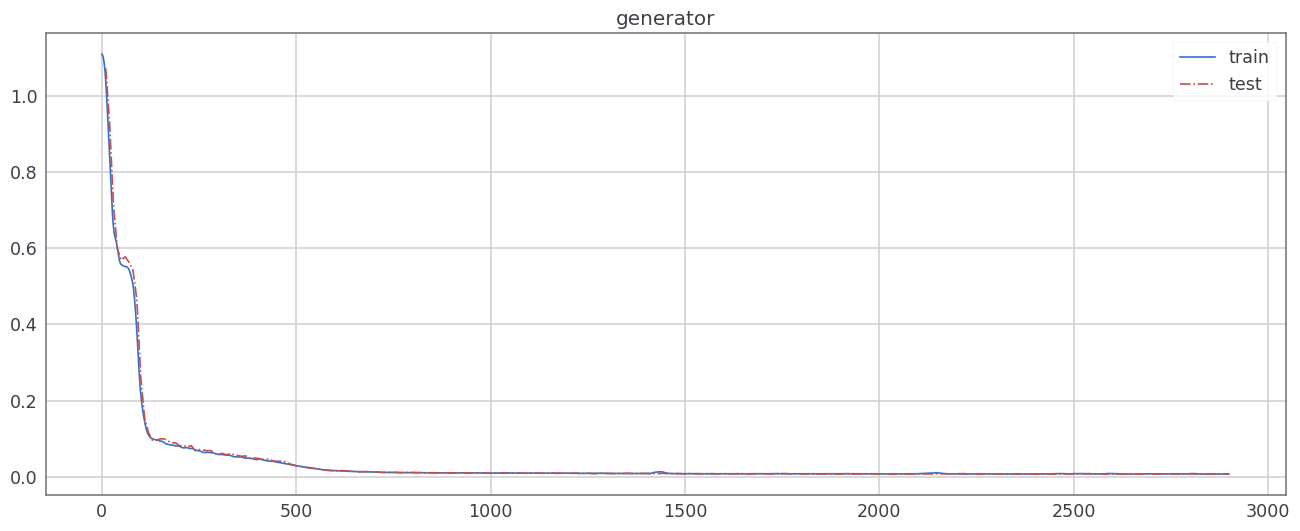

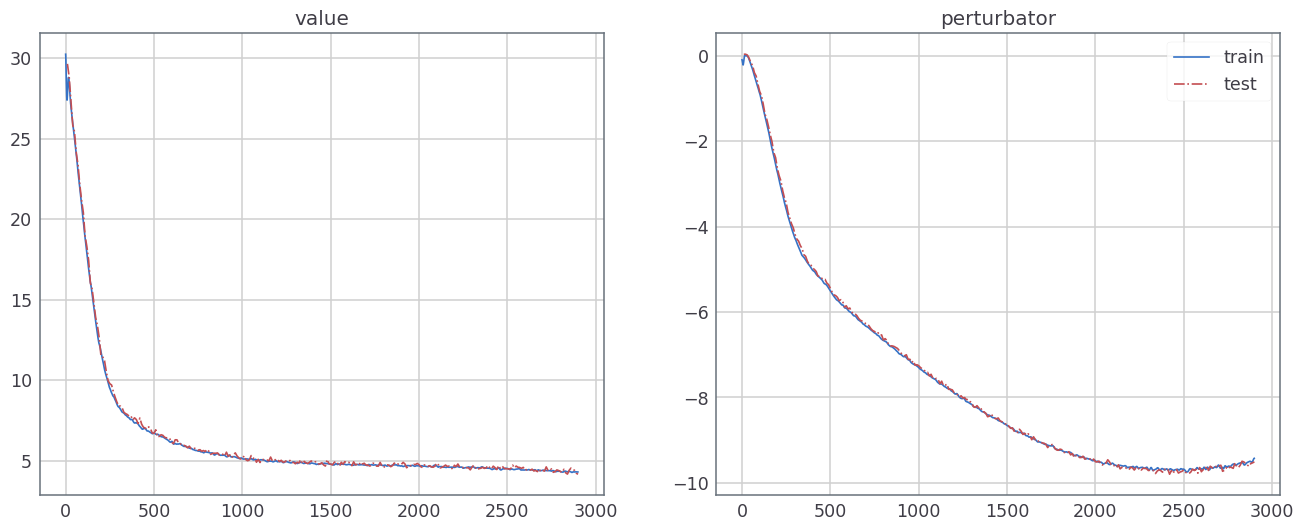

In [10]:
# scheduler_step = 300

for epoch in range(n_epochs):
#     scheduler.step()
    for batch in tqdm(env.train_dataloader):
        loss = bcq_update(batch, params, writer, debug, step=step)
#         scheduler.batch_step()
        plotter.log_losses(loss)
        step += 1
#         if step % scheduler_step == 0:
#             scheduler.step()
        if step % plot_every == 0:
            clear_output(True)
            print('step', step)
            test_loss = run_tests()
            plotter.log_losses(test_loss, test=True)
            plotter.plot_loss()

In [11]:
torch.save(generator_net.state_dict(), "models/bcq_generator.pt")
torch.save(perturbator_net.state_dict(), "models/bcq_perturbator.pt")
torch.save(value_net1.state_dict(), "models/bcq_value1.pt")
torch.save(value_net2.state_dict(), "models/bcq_value2.pt")

In [12]:
from scipy import stats

rs = []

for batch in tqdm(env.test_dataloader):
    state, action, reward, next_state, _ = recnn.data.get_base_batch(batch, device='cpu')
    state_rep = torch.repeat_interleave(state, params['n_generator_samples'], 0)
    sampled_action = generator_net.decode(state_rep)
    recommendation = target_perturbator_net(state_rep, sampled_action)
    for r, a in zip(recommendation, action):
        rs.append(stats.pearsonr(r.detach().numpy(), a.detach().numpy()))
    
print(np.mean(rs))

  0%|          | 0/2 [00:00<?, ?it/s]

0.2843040323671049
